(400, 400)


/tmp/ipykernel_14846/1680429769.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image =  imageio.imread('data/shepp_logan_phantom.png', mode='F')


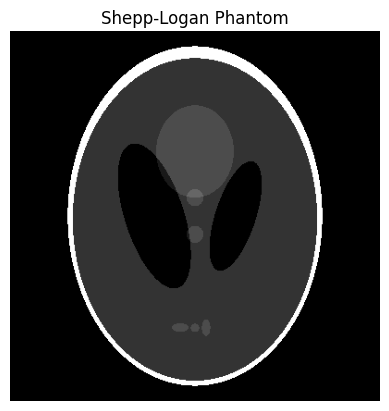

In [75]:
import matplotlib.pyplot as plt
import imageio

# Load the saved Shepp-Logan phantom image
image =  imageio.imread('data/shepp_logan_phantom.png', mode='F')
print(image.shape)
# Display the loaded image
plt.imshow(image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.title('Shepp-Logan Phantom')
plt.show()


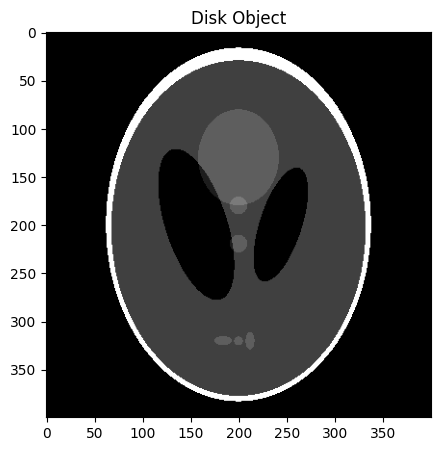

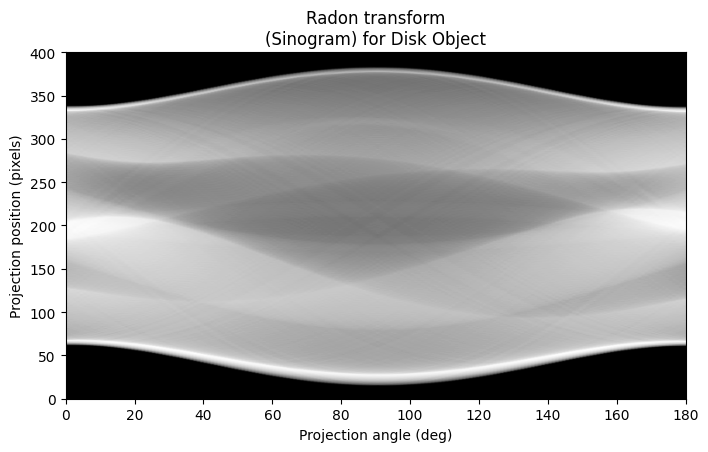

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon
# Function to generate a disk object
# def generate_disk(size, radius, center):
#     x, y = np.meshgrid(np.arange(size[1]), np.arange(size[0]))
#     return ((x - center[0])**2 + (y - center[1])**2) < radius**2

# # Generate a disk object
# size = (120, 120)  # Adjust the size as needed
# radius = 20
# center = (100, 60)
# disk = generate_disk(size, radius, center)

# Display the disk object
plt.figure(figsize=(5, 5))
plt.title("Disk Object")
plt.imshow(image, cmap=plt.cm.Greys_r)
plt.show()

# Radon transform for the disk object
theta = np.arange(180)
sinogram = radon(image, theta=theta)

# Display the sinogram
plt.figure(figsize=(8, 4.5))
plt.title("Radon transform\n(Sinogram) for Disk Object")
plt.xlabel("Projection angle (deg)")
plt.ylabel("Projection position (pixels)")
plt.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]),
           aspect='auto')
plt.show()

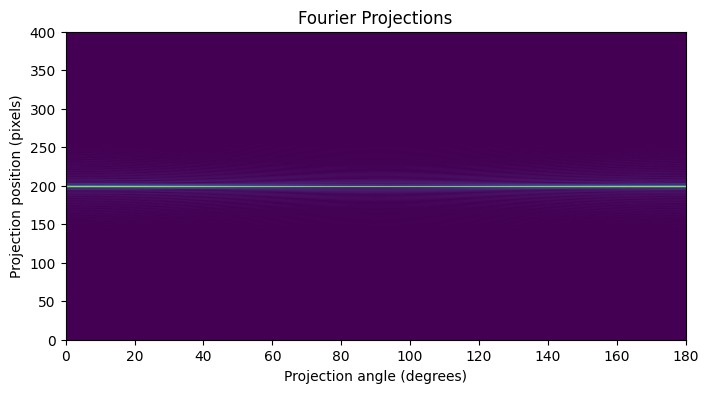

In [78]:
import numpy as np

# Assuming sinogram is your input data

# Shift zero-frequency component to the center along the first dimension
shifted_sinogram = np.fft.ifftshift(sinogram, axes=0)

# Compute the FFT along the first dimension
proj_fft = np.fft.fft(shifted_sinogram, axis=0)

# Get the length of the FFT
N = proj_fft.shape[0]

# Create the filter
filt = np.concatenate([2 * np.arange(N // 2 + 1) / N, 2 * np.arange(N // 2 - 1, 0, -1) / N])

# Ensure the filter has the correct length
filt = filt[:N]

# Shift the zero-frequency component of the filter to the center
H = np.fft.ifftshift(filt)

# Apply the filter in the frequency domain
proj_fft = proj_fft * np.tile(H[:, np.newaxis], (1, proj_fft.shape[1]))

# Shift the zero-frequency component back to the corner
proj_fft = np.fft.fftshift(proj_fft, axes=0)
# Display the Fourier projections
plt.figure(figsize=(8, 4))
plt.title("Fourier Projections")
plt.xlabel("Projection angle (degrees)")
plt.ylabel("Projection position (pixels)")
plt.imshow(np.abs(proj_fft), cmap='viridis', aspect='auto', extent=(0, 180, 0, proj_fft.shape[0]))
plt.show()

/tmp/ipykernel_14846/3594131597.py:55: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(np.abs(I[pad:-pad, pad:-pad]), cmap='gray')
/tmp/ipykernel_14846/3594131597.py:55: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(np.abs(I[pad:-pad, pad:-pad]), cmap='gray')


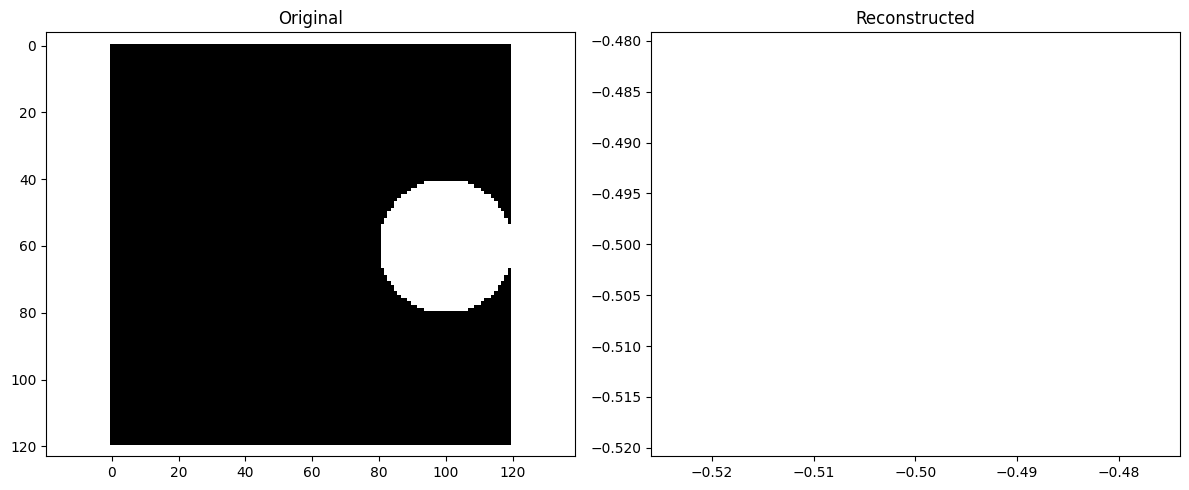

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Assuming 'phntm' is your image and 'proj_fft' is the Fourier projections

N = disk.shape[0]

# Define omega_r
if N % 2 == 1:
    omega_r = np.arange(-N/2, (N-1)/2 + 1) * (2 * np.pi / N)
else:
    omega_r = np.arange(-(N-1)/2, (N-1)/2 + 1) * (2 * np.pi / N)

# Define omega_theta
omega_theta = theta * np.pi / 180

# Create radial grid for FFT values
theta_grid, r_grid = np.meshgrid(omega_theta, omega_r)

# Create Cartesian grid for 2D FFT values
omega_grid_x, omega_grid_y = np.meshgrid(omega_r, omega_r)

# Transform Cartesian to polar coordinates
coord_th_fft2, coord_r_fft2 = np.arctan2(omega_grid_y, omega_grid_x), np.sqrt(omega_grid_x**2 + omega_grid_y**2)
coord_r_fft2 = coord_r_fft2 * np.sign(coord_th_fft2)

# Adjust theta for theta > pi
coord_th_fft2 = coord_th_fft2 + np.pi / 2
coord_th_fft2[coord_th_fft2 < 0] += np.pi

# Interpolate coefficients to the grid points
FFT2 = griddata((theta_grid.ravel(), r_grid.ravel()), proj_fft.ravel(),
                (coord_th_fft2, coord_r_fft2), method='linear', fill_value=0)

# Reshape the result to match the shape of coord_th_fft2 and coord_r_fft2
FFT2 = FFT2.reshape(coord_th_fft2.shape)

# Flip the result
FFT2 = np.flipud(FFT2)

# Inverse FFT
I = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(FFT2)))

# Display the original and reconstructed images
pad = np.ceil((N - disk.shape[0]) / 2).astype(int)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(disk, cmap='gray')
plt.title('Original')
plt.axis('equal')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.imshow(np.abs(I[pad:-pad, pad:-pad]), cmap='gray')
plt.title('Reconstructed')
plt.axis('equal')
plt.tight_layout()
import numpy as np

# Assuming sinogram is your input data

# Shift zero-frequency component to the center along the first dimension
shifted_sinogram = np.fft.ifftshift(sinogram, axes=0)

# Compute the FFT along the first dimension
proj_fft = np.fft.fft(shifted_sinogram, axis=0)

# Get the length of the FFT
N = proj_fft.shape[0]

# Create the filter
filt = np.concatenate([2 * np.arange(N // 2 + 1) / N, 2 * np.arange(N // 2 - 1, 0, -1) / N])

# Ensure the filter has the correct length
filt = filt[:N]

# Shift the zero-frequency component of the filter to the center
H = np.fft.ifftshift(filt)

# Apply the filter in the frequency domain
proj_fft = proj_fft * np.tile(H[:, np.newaxis], (1, proj_fft.shape[1]))

# Shift the zero-frequency component back to the corner
proj_fft = np.fft.fftshift(proj_fft, axes=0)